# Exploration of the data

#### Get path to the raw data

In [53]:
import os
from pathlib import Path

from dotenv import load_dotenv
load_dotenv()
root_data = os.getenv("KAGGLE_FILES_DIR")
dataset_path = Path(os.getcwd(), "..", root_data)
raw = Path(dataset_path, "raw")

#### Read CSVs files with labels

In [3]:
import pandas as pd

labels_traintest15_train19 = pd.read_csv(Path(raw, 'labels', 'traintestLabels15_trainLabels19.csv'), header=0, usecols=["image", "level"])
labels_train19 = pd.read_csv(Path(raw, 'labels', 'trainLabels19.csv'), header=0, usecols=["id_code", "diagnosis"])
labels_train19.rename(columns={"id_code": "image", "diagnosis": "level"}, inplace=True)  # rename columns to match other datasets

labels_train15 = pd.read_csv(Path(raw, 'labels', 'trainLabels15.csv'), header=0, usecols=["image", "level"])
labels_test15 = pd.read_csv(Path(raw, 'labels', 'testLabels15.csv'), header=0, usecols=["image", "level"])


#### Shapes of labels CSVs

In [4]:
print(labels_traintest15_train19.shape)
print(labels_train19.shape)
print(labels_train15.shape)
print(labels_test15.shape)

(92364, 2)
(3662, 2)
(35126, 2)
(53576, 2)


#### Concatenate all labels with no duplicates

In [5]:
labels = pd.concat([labels_traintest15_train19, labels_train19, labels_train15, labels_test15], ignore_index=True).drop_duplicates()
labels.shape

(92364, 2)

##### Looks like `labels_traintest15_train19` labels contains all unique data.

#### Check images directories length

In [6]:
imgs_15 = Path(raw, 'resized_traintest15_train19')
imgs_19 = Path(raw, 'resized_test19')

print(len(list(imgs_15.glob("*"))))
print(len(list(imgs_19.glob("*"))))


92364
1928


#### Check if `traintestLabels15_trainLabels19.csv` contains all images from `resized_traintest15_train19`.

In [ ]:
missing = []

for label in labels[["image"]].values:
    p = Path(imgs_15, f"{label[0]}.jpg")
    if not p.exists():
        missing.append(label)
        print(f"Image {label[0]} not found in `resized_traintest15_train19`")

#### All images from `traintestLabels15_trainLabels19.csv` are present in `resized_traintest15_train19`.
#### Other CSVs and resized_test19 directory are not removed.

In [25]:
import shutil
shutil.rmtree(imgs_19)
shutil.move(imgs_15, Path(raw, "images"))
labels.to_csv(Path(raw, "labels.csv"), index=False)
shutil.rmtree(Path(raw, "labels"))

#### Make dirs for clases of data

In [33]:
retinopathy_severity = {
    0: "healthy",
    1: "mild",
    2: "moderate",
    3: "severe",
    4: "proliferative"
}
for severity in retinopathy_severity.values():
    os.makedirs(Path(raw, severity), exist_ok=True)

#### Move images to their classes

In [51]:
from tqdm import tqdm
images = Path(raw, "images")

for image in tqdm(images.glob("*")):
    label = labels[labels["image"] == image.stem]["level"].values[0]
    shutil.move(image, Path(raw, retinopathy_severity[label], image.name))

shutil.rmtree(images)

#### Split images into train, validation and test sets (70%/20%/10%)

In [54]:
import splitfolders

processed = Path(dataset_path, 'processed')
os.makedirs(processed, exist_ok=True)

splitfolders.ratio(raw, output=processed, seed=42, ratio=(0.7, 0.2, 0.1))

Copying files: 92364 files [00:58, 1584.17 files/s]


# Create train, validation, test datasets

In [1]:
import os
from pathlib import Path

from dotenv import load_dotenv
load_dotenv()
root_data = os.getenv("KAGGLE_FILES_DIR")
dataset_path = Path(os.getcwd(), "..", root_data)

In [3]:
import torchvision

split = Path(dataset_path, 'processed')
train_dataset = torchvision.datasets.ImageFolder(root=str(Path(split, 'train')), transform=None)
val_dataset = torchvision.datasets.ImageFolder(root=str(Path(split, 'val')), transform=None)
test_dataset = torchvision.datasets.ImageFolder(root=str(Path(split, 'test')), transform=None)

In [5]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

64653
18471
9240


## Explore image sizes

100%|██████████| 6466/6466 [01:17<00:00, 83.37it/s] 


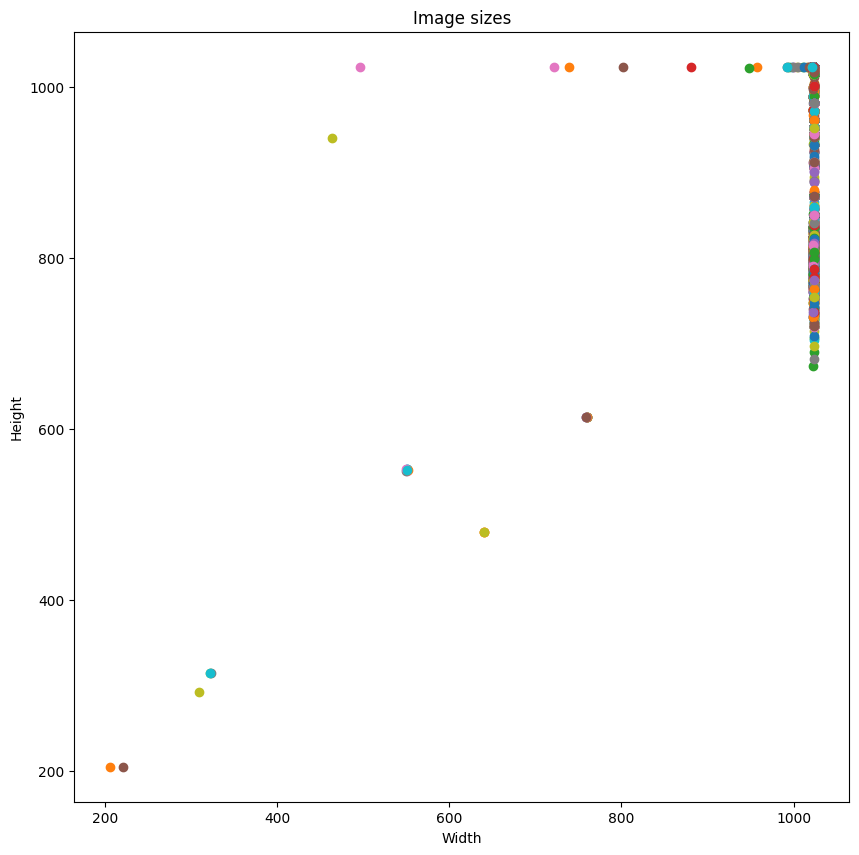

Lowest width: 205, lowest height: 205
Highest width: 1024, highest height: 1024
Average width: 1021.7704918032787, average height: 913.9655119084441


In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm

highest_width = 0
highest_height = 0

lowest_width = float("inf")
lowest_height = float("inf")

avg_width = 0
avg_height = 0

figure = plt.figure(figsize=(10, 10))

ran = range(1, len(train_dataset), 10)
for _ in tqdm(ran):
    img, label = train_dataset[_]
    size = img.size
    
    avg_width += size[0]
    avg_height += size[1]
    
    if size[0] < lowest_width:
        lowest_width = size[0]
    if size[1] < lowest_height:
        lowest_height = size[1]
    
    if size[0] > highest_width:
        highest_width = size[0]
    if size[1] > highest_height:
        highest_height = size[1]
    
    plt.scatter(size[0], size[1])
    

plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image sizes")
plt.show()
print(f"Lowest width: {lowest_width}, lowest height: {lowest_height}")
print(f"Highest width: {highest_width}, highest height: {highest_height}")
print(f"Average width: {avg_width / len(ran)}, average height: {avg_height / len(ran)}")

Average size is close to 1024x1024, but images will be resized to quarter this size - 512x512, to speed up training.
Very little images will be upscaled, so information loss should be minimal.

### Add transforms to the dataset

In [ ]:
from torchvision import transforms
transformations = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.ImageFolder(root=str(Path(split, 'train')), transform=transformations)
val_dataset = torchvision.datasets.ImageFolder(root=str(Path(split, 'val')), transform=transformations)
test_dataset = torchvision.datasets.ImageFolder(root=str(Path(split, 'test')), transform=transformations)

### Visualize some images from train dataset

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

DR_CLASSES = {
    0: "healthy",
    1: "mild",
    2: "moderate",
    3: "severe",
    4: "proliferative"
}

figure = plt.figure(figsize=(15, 15))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(DR_CLASSES[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    

# Dataloaders

In [56]:
BATCH_SIZE = 16
LOADER_WORKERS = 8

transformations = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(root=str(Path(split, 'train')), transform=transformations)
val_dataset = torchvision.datasets.ImageFolder(root=str(Path(split, 'val')), transform=transformations)
test_dataset = torchvision.datasets.ImageFolder(root=str(Path(split, 'test')), transform=transformations)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKERS)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKERS)


### Size of datasets

In [57]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 64653
Validation dataset size: 18471
Test dataset size: 9240


In [58]:
image, label = train_dataset[0]
print(image.shape[0])
print(label)

3
0


# Define classifier
### Using CNN with 3 convolutional layers and 2 fully connected layers.

In [59]:
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, input_size: torch.Size, initial_filters: int, out_classes: int, dropout: float = 0.25, device: str = "cpu", ):
        super(CNN, self).__init__()
        channels, _, _ = input_size
        self.device = device
        self.conv = nn.Sequential(
            nn.Conv2d(channels, initial_filters, kernel_size=3, stride=1, padding=1, device=self.device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(initial_filters, initial_filters * 2, kernel_size=3, stride=1, padding=1, device=self.device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(initial_filters * 2, initial_filters * 4, kernel_size=3, stride=1, padding=1, device=self.device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.perceptron = nn.Sequential(
            nn.Linear(self._get_conv_out_shape(input_size), initial_filters * 8, device=self.device),
            nn.Dropout(dropout),
            nn.Linear(initial_filters * 8, out_classes, device=self.device),
        )
    
    def forward(self, x: torch.Tensor):
        x = x.to(self.device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.perceptron(x)
        return x
    
    def _get_conv_out_shape(self, input_size: torch.Size):
        with torch.no_grad():
            zeros = torch.zeros(*input_size, device=self.device)
            z = self.conv(zeros)
            z = torch.prod(torch.tensor(z.shape))
        return z


In [60]:
class EarlyStopper:
    def __init__(self, patience: int = 5, min_delta: float = 0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

For evaluation of the model, I will use accuracy and cross-entropy loss.

In [61]:
def evaluate(model: nn.Module, valid_loader: torch.utils.data.DataLoader, criterion: nn.Module):    
    model.eval()
    epoch_loss = 0
    correct_class = 0
    
    dataset_size = len(valid_loader.dataset)
    
    with torch.no_grad():
        device = model.device
        for X_batch, y_batch in tqdm(valid_loader, desc="Validation: "):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            y_pred = torch.argmax(output, dim=1)  # argmax or softmax?
            correct_class += (y_pred == y_batch).sum()
            loss = criterion(output, y_batch)
            epoch_loss += loss.item() * X_batch.size(0)
    
    avg_epoch_loss = epoch_loss / dataset_size
    accuracy = correct_class / dataset_size
    return avg_epoch_loss, accuracy

In [62]:
import torch.optim as optim

from tqdm import tqdm

def train(
        model: nn.Module, 
        train_loader: torch.utils.data.DataLoader,
        valid_loader: torch.utils.data.DataLoader,
        max_epochs: int,
        optimizer: optim.Optimizer, 
        criterion: nn.Module,
        patience: int = 3,
        min_delta: float = 0.001,
):
    device = model.device
    early_stopping = EarlyStopper(patience=patience, min_delta=min_delta)
    for epoch in range(max_epochs):
        model.train()
        for X_batch, y_batch in tqdm(train_loader, desc=f"Train epoch {epoch}: "):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        avg_epoch_loss, accuracy = evaluate(model, valid_loader, criterion, device=device)
        print(f"Epoch: {epoch}\nAverage epoch loss: {avg_epoch_loss:.3f}\nAccuracy: {accuracy:.3f}")
        
        if early_stopping.early_stop(avg_epoch_loss):
            print(f'Early stopping on epoch {epoch}, validation loss: {avg_epoch_loss:.3f}, accuracy: {accuracy:.3f}')
            break


In [63]:
image, label = train_dataset[0]
model_params = {
    "input_size": image.shape,
    "initial_filters": BATCH_SIZE,
    "out_classes": len(train_dataset.classes),
    "device": "mps"
}
cnn = CNN(**model_params)

criterion = nn.CrossEntropyLoss()  # weighted or not?
optimizer = optim.SGD(cnn.parameters(), lr=0.01)

n_epochs = 50

In [64]:
train(cnn, train_loader, val_loader, n_epochs, optimizer, criterion, device="mps")

Train epoch 0:   2%|▏         | 88/4041 [00:10<04:12, 15.66it/s] Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x120b8ee80>
Traceback (most recent call last):
  File "/Users/isulim/Sages/brain-cnn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/isulim/Sages/brain-cnn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/isulim/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isulim/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isulim/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/connection.py", l

KeyboardInterrupt: 